In [1]:
import warnings
import numpy   as np
import pandas  as pd
import seaborn as sea
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

C:\Users\mateu\AppData\Local\Temp\ipykernel_11008\3597380226.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas  as pd


In [2]:
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings(action='ignore',category=FitFailedWarning)
warnings.filterwarnings(action='ignore',category=UserWarning)

In [3]:
data = pd.read_csv(r'datasets/DiabetesPredictionClassification/diabetes_prediction_dataset.csv')

In [4]:
data.head(4)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0


&nbsp;
O nível de HbA1c (hemoglobina A1c) é uma medida do nível médio de açúcar no sangue de uma pessoa nos últimos 2-3 meses. Níveis mais altos

&nbsp;

# Analise dos dados

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


Verificando valores nulos no meu conjunto de dados

In [7]:
data.loc[ data.isna().any(axis=1) ]

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes


In [8]:
data.loc[ data.isna().any(axis=1) ]

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes


### Diabetes

In [9]:
countDiabetes = data['diabetes'].value_counts().reset_index(name='quantidade')

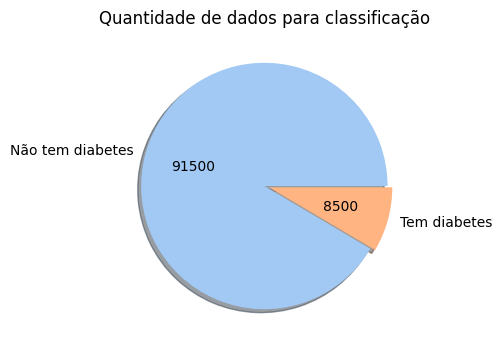

In [10]:
plt.figure(figsize=(5,4))
plt.pie( x = countDiabetes['quantidade'], explode=(0,0.04) , labels = ['Não tem diabetes','Tem diabetes'],autopct=lambda x: '{:.0f}'.format(x*countDiabetes['quantidade'].sum()/100) ,colors=sea.color_palette('pastel')[0:2],shadow=True)
plt.title('Quantidade de dados para classificação')
plt.show()

Os atributo `Diabetes` está desbalanceados com isso para a classificação se faz necessário o balaceamento dele. \
Como as pessoas que não tem diabetes está em mais quantidade ( muito mais) do que as que tem diabetes , irei fazer UnderSampling para o balanceamento dos dados.  

### Gender

In [11]:
data['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [12]:
data.loc[data['gender']=='Other'][['diabetes','hypertension','heart_disease','smoking_history']].value_counts().reset_index()

,diabetes,hypertension,heart_disease,smoking_history,count
0,0,0,0,not current,8
1,0,0,0,No Info,6
2,0,0,0,never,3
3,0,0,0,ever,1


In [13]:
print('Média de idade para pessoas de outro gênero :',data.loc[data['gender']=='Other']['age'].mean())

Média de idade para pessoas de outro gênero : 29.555555555555557


Esses dados para pessoa `gender` == `other` são redundantes, os valores dos atributos `hypertension` , `heart_disease` em relação `diabete` não muda continua 0, além de não mudar o valor do atributo `diabetes` continua zero. \
Com isso será removido do conjunto de dados.

In [14]:
data.drop( index = data.loc[ data['gender'] == 'Other'].index , inplace = True )

In [15]:
countGender = data['gender'].value_counts().reset_index(name='Quantidade')

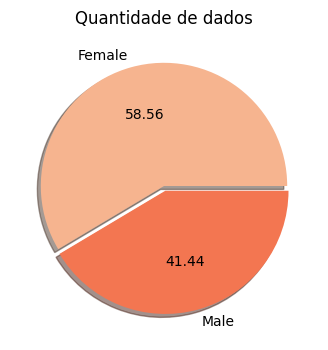

In [16]:
plt.figure(figsize=(10,4))
plt.pie( x = countGender['Quantidade'], explode=(0,0.04) , labels = countGender['gender'] ,colors = sea.color_palette('rocket_r')[0:2] , autopct='%.2f' ,shadow=True )
plt.title('Quantidade de dados')
plt.show()

Possui muito mais dados do genero feminino que o masculino. 

In [17]:
countGenderDiabetes = data.groupby( by=['gender','diabetes'] )['age'].mean().reset_index(name='Média de idade')

In [18]:
SelectDiatebes0 = data.loc[data['diabetes'] == 0][['age','gender']]
SelectDiatebes1 = data.loc[data['diabetes'] == 1][['age','gender']]

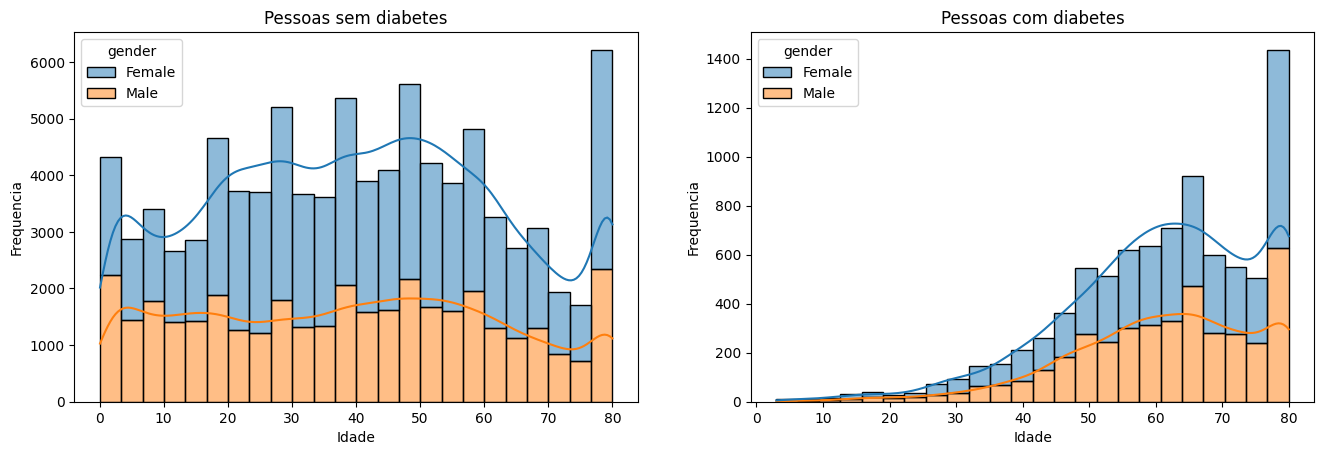

In [19]:
fig , ax = plt.subplots(1,2)
fig.set_figwidth(16)

#Sem diabetes
sea.histplot(
    x = SelectDiatebes0['age'], hue = SelectDiatebes0['gender'] , ax = ax[0] ,multiple="stack", 
    kde = True, shrink = 1 , bins = 24
)
ax[0].set_xlabel('Idade')
ax[0].set_ylabel('Frequencia')
ax[0].set_title('Pessoas sem diabetes')

# Com diabetes
sea.histplot(
    x = SelectDiatebes1['age'], hue = SelectDiatebes1['gender'], ax = ax[1] , multiple="stack", 
    kde= True, shrink=1, bins = 24
)
ax[1].set_xlabel('Idade')
ax[1].set_ylabel('Frequencia')
ax[1].set_title('Pessoas com diabetes')

plt.show()

In [20]:
groupGenHype = data.groupby( by = ['gender'])['hypertension'].value_counts().reset_index(name = 'Quantidade')

In [21]:
groupGenHeart = data.groupby( by = ['gender'])['heart_disease'].value_counts().reset_index(name = 'Quantidade')

In [22]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

groupGenHype['hypertension'].loc[groupGenHype['hypertension'] == 0]     = 'Não tem hipertensão'
groupGenHype['hypertension'].loc[groupGenHype['hypertension'] == 1]     = 'Tem hipertensão'
groupGenHeart['heart_disease'].loc[groupGenHeart['heart_disease'] == 0] = 'Não doença cardiaca'
groupGenHeart['heart_disease'].loc[groupGenHeart['heart_disease'] == 1] = 'Tem doençã cardiaca'

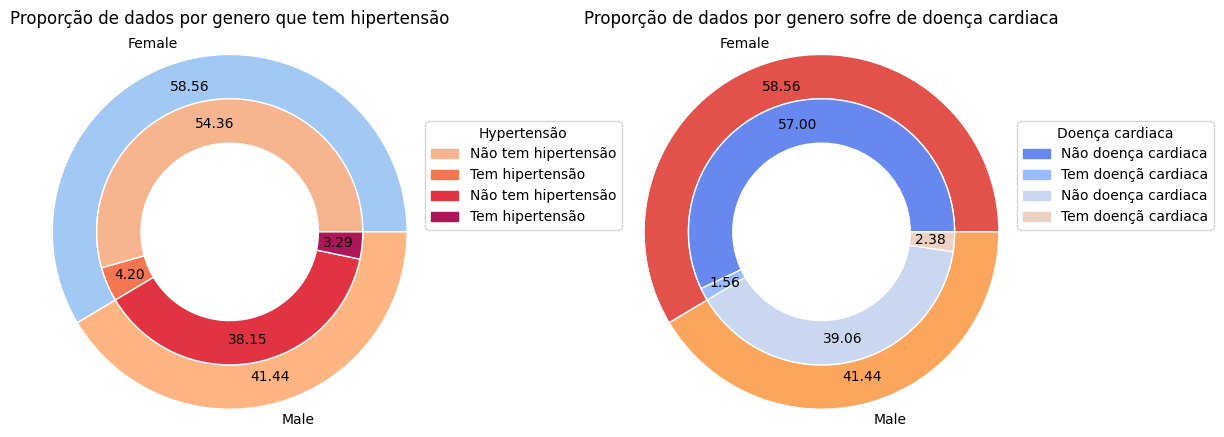

In [23]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)
colors1 = sea.color_palette('pastel')[0:2] 
colors2H = sea.color_palette('rocket_r')[0:4] 


ax[0].pie(x = groupGenHype.groupby(by=['gender'])['Quantidade'].sum(), labels= groupGenHype['gender'].drop_duplicates().values ,
       wedgeprops = dict(width=0.3, edgecolor='w'), autopct='%.2f' , pctdistance =0.85 ,colors=colors1 ,radius=1.2)

ax[0].pie(x = groupGenHype.groupby(by=['gender','hypertension'])['Quantidade'].sum() ,wedgeprops=dict(width=0.3, edgecolor='w'),
       radius=.9,autopct='%.2f',pctdistance=0.82 ,colors=colors2H )

colors1 = sea.color_palette('Spectral')[0:2]
colors2 = sea.color_palette('coolwarm')[0:6] 

ax[1].pie(x = groupGenHeart.groupby(by=['gender'])['Quantidade'].sum(), labels= groupGenHype['gender'].drop_duplicates().values ,
       wedgeprops = dict(width=0.3, edgecolor='w'), autopct='%.2f' , pctdistance =0.85 ,colors=colors1 ,radius=1.2)

ax[1].pie(x = groupGenHeart.groupby(by=['gender','heart_disease'])['Quantidade'].sum() ,wedgeprops=dict(width=0.3, edgecolor='w'),
       radius=.9,autopct='%.2f',pctdistance=0.82 ,colors=colors2 )

legends = []
for value, color in zip(groupGenHype['hypertension'].values, colors2H): 
       legends.append(mpatches.Patch(color=color, label=value))

legends2 = []
for value, color in zip(groupGenHeart['heart_disease'].values, colors2): 
       legends2.append(mpatches.Patch(color=color, label=value))

ax[0].legend(title='Hypertensão'    ,handles=legends, bbox_to_anchor=(1.01,0.519,0,0.3))
ax[1].legend(title='Doença cardiaca',handles=legends2, bbox_to_anchor=(1.01,0.519,0,0.3))

ax[0].set_title('Proporção de dados por genero que tem hipertensão',y=1.04)
ax[1].set_title('Proporção de dados por genero sofre de doença cardiaca',y=1.04)

plt.show()

In [24]:
genderGroupby =data.loc[data['diabetes']==1].groupby(by=['gender','hypertension','heart_disease'])['age'].apply(lambda x:x).reset_index()

In [25]:
genderGroupby = pd.concat([genderGroupby.drop(columns='age'),pd.cut(genderGroupby['age'],20)],axis=1)
genderGroupby.head(3)

,gender,hypertension,heart_disease,level_3,age
0,Female,0,0,6,"(41.5, 45.35]"
1,Female,0,0,53,"(49.2, 53.05]"
2,Female,0,0,59,"(64.6, 68.45]"


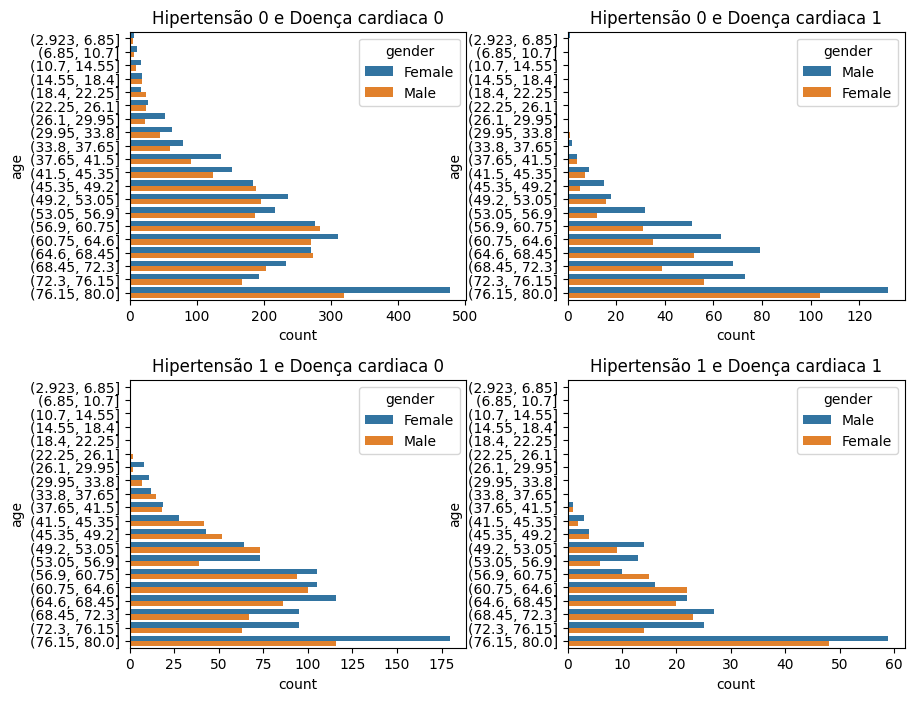

In [26]:
from itertools import product
fig , ax = plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(8)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in list(product([0,1],repeat=2)):
    select = genderGroupby.loc[ (genderGroupby['hypertension' ]== i[0]) & (genderGroupby['heart_disease']== i[1])
                                ][['age','gender']].value_counts().reset_index() 
    
    ax[i[0],i[1]].set_title(f'Hipertensão {i[0]} e Doença cardiaca {i[1]}')
    sea.barplot(x=select['count'],y=select['age'],hue=select['gender'],orient='h',ax=ax[i[0],i[1]])

> Esse grafico assima e para as pessoas que tem diabetes

### Hipertensão

[]

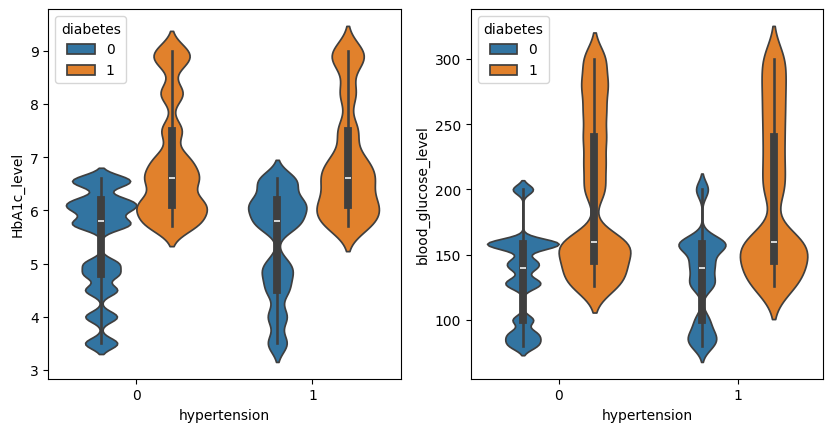

In [27]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(10)
sea.violinplot(x = data['hypertension'] , y= data['HbA1c_level'] , hue=data['diabetes'] ,ax = ax[0])
sea.violinplot(x = data['hypertension'] ,y= data['blood_glucose_level'] , hue=data['diabetes'], ax= ax[1])
plt.plot()

In [28]:
data.groupby( by = ['smoking_history' ,'diabetes'] ).size().apply(lambda x:(x*100)/data['smoking_history'].count()).reset_index(name='%')

,smoking_history,diabetes,%
0,No Info,0,34.362185
1,No Info,1,1.454262
2,current,0,8.339501
3,current,1,0.948171
4,ever,0,3.531636
5,ever,1,0.472085
6,former,0,7.763397
7,former,1,1.590286
8,never,0,31.751715
9,never,1,3.346602


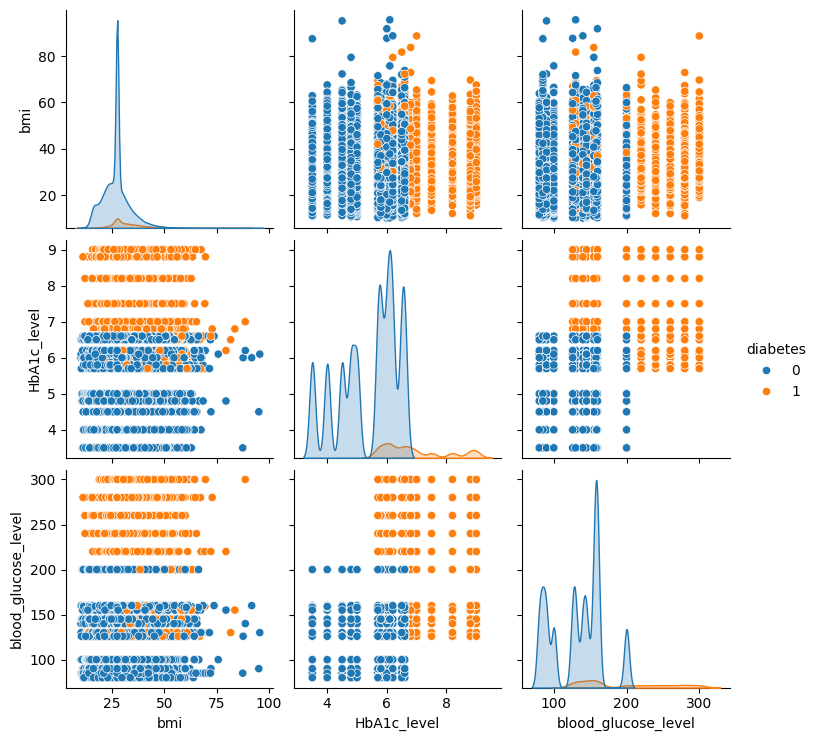

In [29]:
sea.pairplot(data[['diabetes','bmi','HbA1c_level','blood_glucose_level']],hue='diabetes')
plt.show()

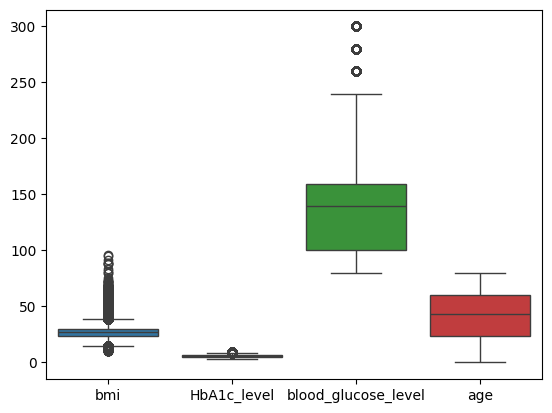

In [30]:
sea.boxplot(data[['bmi','HbA1c_level','blood_glucose_level','age']])
plt.show()

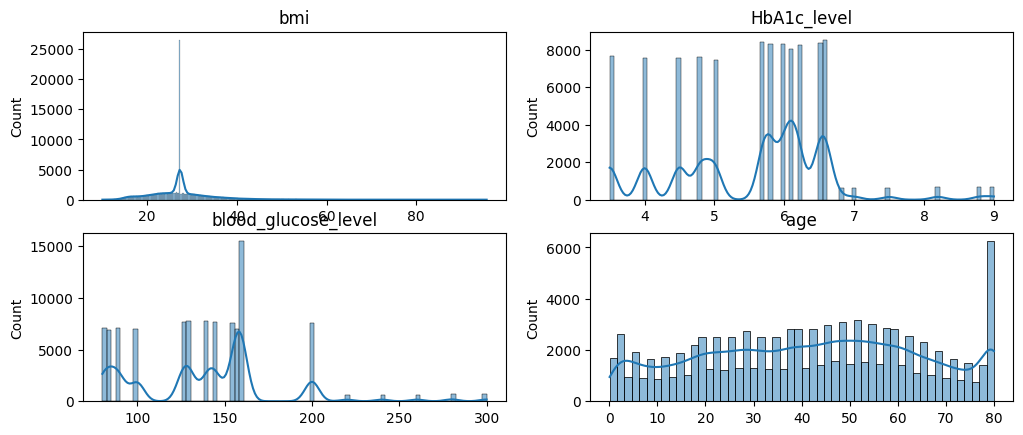

In [31]:
fig , ax = plt.subplots(2,2)
index = 0
lista = ['bmi','HbA1c_level','blood_glucose_level','age']

fig.set_figwidth(12)
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(lista[index])
        sea.histplot( data[lista[index]].values,kde=True,ax=ax[i,j])
        index +=1
plt.show()

> para esse atributos se faz necessario a remoção de outlier, normalizar os dados \
_futuro_

&nbsp;

&nbsp;

# Classificação

In [32]:
from sklearn.metrics         import *
from sklearn.preprocessing   import (
    LabelBinarizer,
    LabelEncoder,
    MaxAbsScaler,
    StandardScaler)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score , 
    GridSearchCV    , 
    RandomizedSearchCV , 
    StratifiedKFold
)

In [33]:
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree         import DecisionTreeClassifier,export_graphviz
from sklearn.svm          import LinearSVC
from graphviz             import Source
from sklearn.ensemble     import RandomForestClassifier

In [34]:
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier      import ROCAUC

In [35]:
data = pd.read_csv(r'datasets/DiabetesPrediction/diabetes_prediction_dataset.csv')

### Preprocessamento

In [36]:
classeGender = LabelBinarizer()
data['gender'] = classeGender.fit_transform(data['gender'])

In [37]:
classSmoking = LabelEncoder()
data['smoking_history'] = classSmoking.fit_transform(data['smoking_history'])

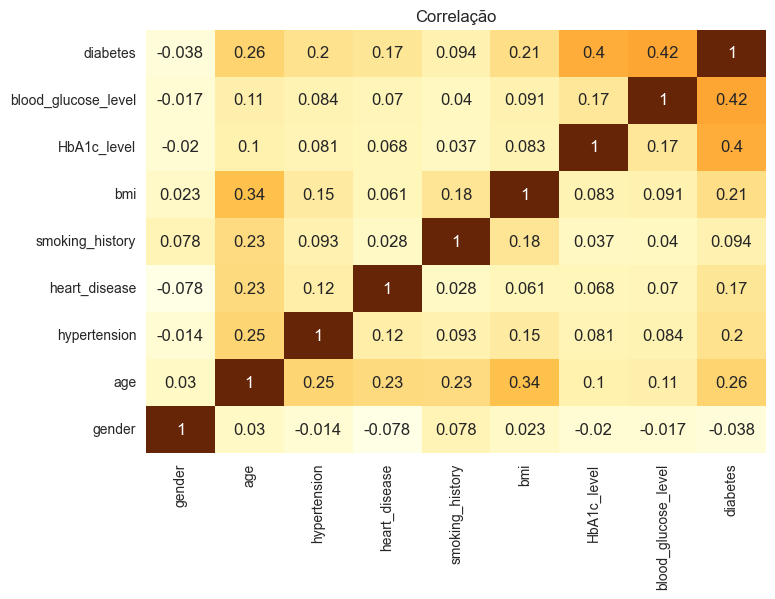

In [38]:
sea.heatmap(data.corr()[::-1],annot=True,cmap='YlOrBr',cbar=False)
plt.title('Correlação')
plt.show()

In [39]:
dataset = pd.get_dummies(data,columns=['smoking_history','gender','hypertension','heart_disease'],dtype=int)

### Padronização | Normalização

In [40]:
dataset[
    ['bmi','HbA1c_level','blood_glucose_level','age']
        ] = MaxAbsScaler().fit_transform(dataset[['bmi','HbA1c_level','blood_glucose_level','age']])

In [41]:
dataset.head(4)

,age,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_0,smoking_history_1,smoking_history_2,smoking_history_3,smoking_history_4,smoking_history_5,gender_0,gender_1,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1
0,1.000,0.263246,0.733333,0.466667,0,0,0,0,0,1,0,0,1,1,0,0,1
1,0.675,0.285505,0.733333,0.266667,0,1,0,0,0,0,0,0,1,1,0,1,0
2,0.350,0.285505,0.633333,0.526667,0,0,0,0,0,1,0,1,0,1,0,1,0
3,0.450,0.245062,0.555556,0.516667,0,0,1,0,0,0,0,0,1,1,0,1,0


In [42]:
dataset['bmi'] = np.log10(dataset['bmi'])

### UnderSampling
Balanceando os dados, há mais dados `0` não tem diabetes do que `1` tem diabetes

In [43]:
from imblearn.under_sampling import RandomUnderSampler

In [44]:
under = RandomUnderSampler(sampling_strategy = 'majority' , random_state=42)

In [45]:
X = dataset.drop( columns = ['diabetes'])
Y = dataset['diabetes']
Y.value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

In [46]:
xUnder ,yUnder = under.fit_resample(X,Y)

In [47]:
yUnder.value_counts()

diabetes
0    8500
1    8500
Name: count, dtype: int64

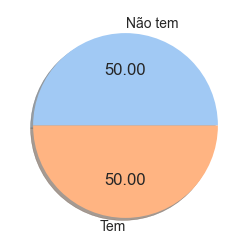

In [48]:
p = yUnder.value_counts().reset_index()
plt.figure(figsize=(4,3))
plt.pie( x = p['count'] , labels=['Não tem','Tem'],autopct='%.2f',colors=sea.color_palette('pastel'),shadow=True)
plt.show()

### Dividindo dados de teste e treinamento

In [49]:
xtrain , xtest , ytrain , ytest = train_test_split( xUnder, yUnder.values , test_size=0.20 , random_state=42)

### KNN
Vou ver o melhor parametros para knn e depois fazer a validação cruzada do mesmo

In [50]:
params = {
    'n_neighbors':[10,11],
    'weights'    :['uniform','distance'],
    'algorithm'  :['ball_tree','kd_tree'],
    'p'     :[3,5,7]
}
crossKnn = RandomizedSearchCV(KNeighborsClassifier(),param_distributions=params,scoring='accuracy',n_iter=3)
crossKnn.fit(xtrain,ytrain)

RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=3,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree'],
                                        'n_neighbors': [10, 11], 'p': [3, 5, 7],
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy')

In [51]:
print("Melhor estimador:\n",crossKnn.best_estimator_)
print(crossKnn.best_score_)

Melhor estimador:
 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=11, p=3)
0.8733823529411765


In [52]:
knn = crossKnn.best_estimator_
knn.fit(xtrain,ytrain)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=11, p=3)

In [53]:
pred = knn.predict(xtest)

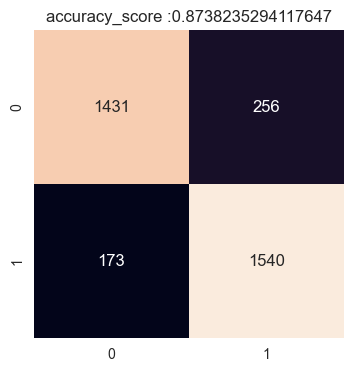

In [54]:
plt.figure(figsize=(4,4))
sea.heatmap( confusion_matrix(ytest,pred), annot=True ,cbar=False,fmt='')
plt.title(f'accuracy_score :{accuracy_score(ytest,pred)}')
plt.show()

In [55]:
print(classification_report(ytest,pred))
print('f1_score',f1_score(ytest,pred))
print('Recall',recall_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1687
           1       0.86      0.90      0.88      1713

    accuracy                           0.87      3400
   macro avg       0.87      0.87      0.87      3400
weighted avg       0.87      0.87      0.87      3400

f1_score 0.877742946708464
Recall 0.8990075890251021


In [56]:
kfold = StratifiedKFold(n_splits=5)
cross_val_score(knn,xUnder,yUnder,cv=kfold,scoring='accuracy')

array([0.88176471, 0.87705882, 0.86764706, 0.87147059, 0.87823529])

#### Gradiente Descedente

In [57]:
params = dict(
    alpha    = np.around(np.linspace(0.1,1,10),2),
    l1_ratio = np.around(np.linspace(0.1,0.9,8),1),
)

gridGrad = GridSearchCV(SGDClassifier(learning_rate='optimal',penalty='elasticnet',eta0=1),param_grid=params,scoring='accuracy',cv=5) 
gridGrad.fit(xtrain,ytrain)

print(gridGrad.best_estimator_)
print(gridGrad.best_score_)

SGDClassifier(alpha=0.1, eta0=1, l1_ratio=0.2, penalty='elasticnet')
0.8087500000000001


In [58]:
grad = gridGrad.best_estimator_
grad.fit(xtrain,ytrain)
predGrad = grad.predict(xtest)

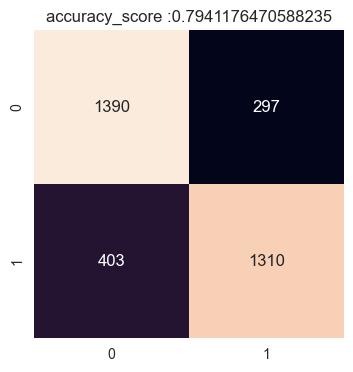

In [59]:
plt.figure(figsize=(4,4))
sea.heatmap( confusion_matrix(ytest,predGrad), annot=True ,cbar=False,fmt='')
plt.title(f'accuracy_score :{accuracy_score(ytest,predGrad)}')
plt.show()

In [60]:
print(classification_report(ytest,predGrad))
print('f1_score',f1_score(ytest,predGrad))
print('Recall',recall_score(ytest,predGrad))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1687
           1       0.82      0.76      0.79      1713

    accuracy                           0.79      3400
   macro avg       0.80      0.79      0.79      3400
weighted avg       0.80      0.79      0.79      3400

f1_score 0.7891566265060241
Recall 0.7647402218330415


&nbsp;

#### Árvore de decisão

In [61]:
params = dict(
    max_depth    = np.arange(3,30),
    max_features = [10],
    max_leaf_nodes = [100,150,200],
    min_samples_split = [150,200]
    
)
gridTree = GridSearchCV(DecisionTreeClassifier(criterion='entropy'),param_grid=params,scoring='accuracy')
gridTree.fit(xtrain,ytrain)

print('Melhor Parametro para o algoritmo:\n',gridTree.best_estimator_)
print(gridTree.best_score_)

Melhor Parametro para o algoritmo:
 DecisionTreeClassifier(criterion='entropy', max_depth=11, max_features=10,
                       max_leaf_nodes=100, min_samples_split=200)
0.9072794117647058


In [62]:
tree =  RandomForestClassifier(criterion='entropy', max_depth=19, max_features=10,max_leaf_nodes=200, min_samples_split=150)
tree.fit(xtrain,ytrain)

RandomForestClassifier(criterion='entropy', max_depth=19, max_features=10,
                       max_leaf_nodes=200, min_samples_split=150)

In [63]:
#tree.get_depth(),tree.get_n_leaves(),tree.tree_.node_count

In [64]:
pred = tree.predict(xtest)

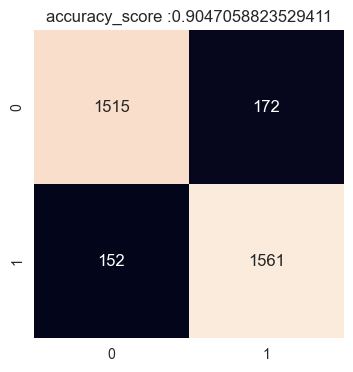

In [65]:
plt.figure(figsize=(4,4))
sea.heatmap( confusion_matrix(ytest,pred), annot=True ,cbar=False,fmt='')
plt.title(f'accuracy_score :{accuracy_score(ytest,pred)}')
plt.show()

In [66]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1687
           1       0.90      0.91      0.91      1713

    accuracy                           0.90      3400
   macro avg       0.90      0.90      0.90      3400
weighted avg       0.90      0.90      0.90      3400



In [67]:
print('f1_score',f1_score(ytest,pred))
print('Recall',recall_score(ytest,pred))

f1_score 0.905977945443993
Recall 0.9112667834208991


In [68]:
kfold = StratifiedKFold(n_splits=5)
cross_val_score(tree,xUnder,yUnder,cv=kfold,scoring='accuracy')

array([0.91852941, 0.91352941, 0.89823529, 0.90411765, 0.91147059])

&nbsp;

#### Regressão Logistica

In [69]:
logistic = LogisticRegression(penalty='l2',solver='newton-cholesky',l1_ratio=1,max_iter=1000,tol=1e-6)
logistic.fit(xtrain,ytrain)

LogisticRegression(l1_ratio=1, max_iter=1000, solver='newton-cholesky',
                   tol=1e-06)

In [70]:
pred = logistic.predict(xtest)

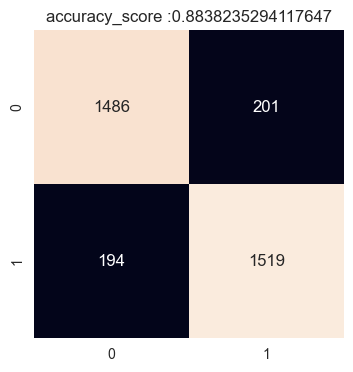

In [71]:
plt.figure(figsize=(4,4))
sea.heatmap( confusion_matrix(ytest,pred), annot=True ,cbar=False,fmt='')
plt.title(f'accuracy_score :{accuracy_score(ytest,pred)}')
plt.show()

In [72]:
print(classification_report(ytest,pred))
print('f1_score',f1_score(ytest,pred))
print('Recall',recall_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1687
           1       0.88      0.89      0.88      1713

    accuracy                           0.88      3400
   macro avg       0.88      0.88      0.88      3400
weighted avg       0.88      0.88      0.88      3400

f1_score 0.8849402854646082
Recall 0.8867483946293053


In [73]:
kfold = StratifiedKFold(n_splits=5)
cross_val_score(logistic,xUnder,yUnder,cv=kfold,scoring='accuracy')

array([0.89058824, 0.88941176, 0.87352941, 0.89      , 0.88794118])

&nbsp;

#### SVM

In [74]:
params = dict(
    C = np.linspace(1,4,4),
)
gridSvm = GridSearchCV(LinearSVC(),param_grid=params ,scoring='accuracy')
gridSvm.fit(xtrain,ytrain)

print(gridSvm.best_estimator_)
print(gridSvm.best_score_)

LinearSVC(C=3.0)
0.8869117647058824


In [75]:
svm = gridSvm.best_estimator_
svm.fit(xtrain,ytrain)
predSvm = svm.predict(xtest)

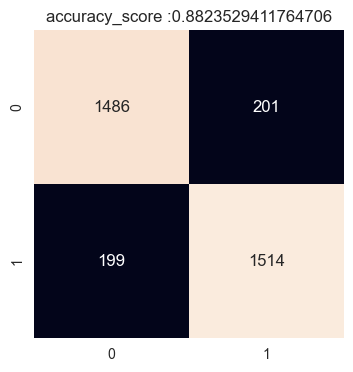

In [76]:
plt.figure(figsize=(4,4))
sea.heatmap( confusion_matrix(ytest,predSvm), annot=True ,cbar=False,fmt='')
plt.title(f'accuracy_score :{accuracy_score(ytest,predSvm)}')
plt.show()

In [77]:
print(classification_report(ytest,predSvm))
print('f1_score',    f1_score(ytest,predSvm))
print('Recall'  ,recall_score(ytest,predSvm))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1687
           1       0.88      0.88      0.88      1713

    accuracy                           0.88      3400
   macro avg       0.88      0.88      0.88      3400
weighted avg       0.88      0.88      0.88      3400

f1_score 0.8833138856476079
Recall 0.8838295388207823


In [78]:
kfold = StratifiedKFold(n_splits=5)
cross_val_score(svm,xUnder,yUnder,cv=kfold,scoring='accuracy')

array([0.89176471, 0.88764706, 0.87382353, 0.89058824, 0.88735294])

> Melhor acuracia foi na  SVM

#### Ensemble

In [79]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
    estimators = [
        ('tree'     ,tree),
        ('logistics',LogisticRegression(solver='liblinear',max_iter=300)),
        ('knn', knn)
    ],
    voting='soft'
)

voting.fit(xtrain,ytrain)
predVot = voting.predict(xtest)

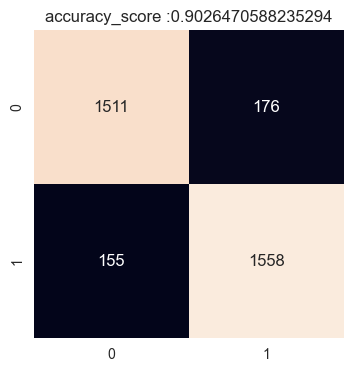

In [80]:
plt.figure(figsize=(4,4))
sea.heatmap( confusion_matrix(ytest,predVot), annot=True ,cbar=False,fmt='')
plt.title(f'accuracy_score :{accuracy_score(ytest,predVot)}')
plt.show()

In [81]:
print(classification_report(ytest,predVot))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1687
           1       0.90      0.91      0.90      1713

    accuracy                           0.90      3400
   macro avg       0.90      0.90      0.90      3400
weighted avg       0.90      0.90      0.90      3400



In [82]:
kfold = StratifiedKFold(n_splits=5)
cross_val_score(voting,xUnder,yUnder,cv=kfold,scoring='accuracy')

array([0.90764706, 0.90764706, 0.88970588, 0.89911765, 0.90352941])

In [83]:
import joblib
joblib.dump(voting,'Model/ModelDiabetes.pki')

['Model/ModelDiabetes.pki']

&nbsp;

## Redes Neurais

In [84]:
import keras

In [85]:
xtrain.shape[1:]

(16,)

In [104]:
input_  = keras.layers.Input(shape=xtrain.shape[1:])
oculta1 = keras.layers.Dense(120, activation='relu')(input_)
oculta2 = keras.layers.Dense(60 , activation='relu')(oculta1)
oculta3 = keras.layers.Dense(30 , activation='relu')(oculta2)
concat  = keras.layers.Concatenate()([input_, oculta3])
output  = keras.layers.Dense(1, activation='relu')(concat)

model = keras.Model(inputs=[input_], outputs=[output])

In [112]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 dense_19 (Dense)            (None, 120)                  2040      ['input_7[0][0]']             
                                                                                                  
 dense_20 (Dense)            (None, 60)                   7260      ['dense_19[0][0]']            
                                                                                                  
 dense_21 (Dense)            (None, 30)                   1830      ['dense_20[0][0]']            
                                                                                            

In [107]:
model.compile( 
    optimizer= keras.optimizers.Adam() , 
    loss     = keras.losses.binary_crossentropy ,
    metrics  = [keras.metrics.binary_accuracy]
)
history = model.fit(xtrain, ytrain, batch_size=20, epochs=10, validation_split=0.1)

Epoch 1/10
612/612 [==============================] - 5s 5ms/step - loss: 0.3719 - binary_accuracy: 0.8665 - val_loss: 0.3510 - val_binary_accuracy: 0.8706
Epoch 2/10
612/612 [==============================] - 3s 4ms/step - loss: 0.3393 - binary_accuracy: 0.8654 - val_loss: 0.3013 - val_binary_accuracy: 0.8647
Epoch 3/10
612/612 [==============================] - 3s 4ms/step - loss: 0.3325 - binary_accuracy: 0.8674 - val_loss: 0.3896 - val_binary_accuracy: 0.8588
Epoch 4/10
612/612 [==============================] - 3s 4ms/step - loss: 0.3599 - binary_accuracy: 0.8519 - val_loss: 0.2979 - val_binary_accuracy: 0.8875
Epoch 5/10
612/612 [==============================] - 3s 4ms/step - loss: 0.3282 - binary_accuracy: 0.8772 - val_loss: 0.3076 - val_binary_accuracy: 0.8699
Epoch 6/10
612/612 [==============================] - 2s 4ms/step - loss: 0.3095 - binary_accuracy: 0.8746 - val_loss: 0.3061 - val_binary_accuracy: 0.8801
Epoch 7/10
612/612 [==============================] - 3s 5ms/ste

<Axes: >

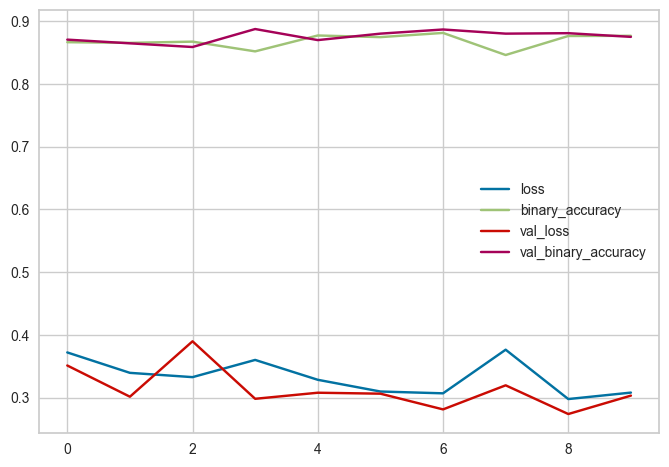

In [111]:
pd.DataFrame(history.history).plot()

In [108]:
pred = model.predict(xtest)>0.5

107/107 [==============================] - 0s 3ms/step


In [109]:
accuracy_score(ytest,pred)

0.8776470588235294

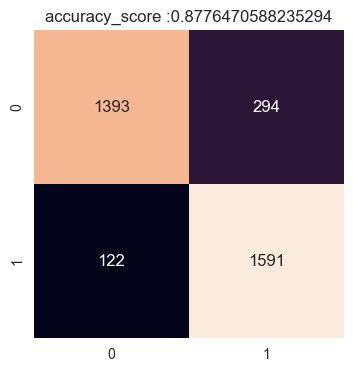

In [110]:
plt.figure(figsize=(4,4))
sea.heatmap( confusion_matrix(ytest,pred), annot=True ,cbar=False,fmt='')
plt.title(f'accuracy_score :{accuracy_score(ytest,pred)}')
plt.show()

In [ ]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1687
           1       0.88      0.89      0.89      1713

    accuracy                           0.89      3400
   macro avg       0.89      0.89      0.89      3400
weighted avg       0.89      0.89      0.89      3400

